## LDA 3

# Fitting an LDA to our corpus

We plan to perform topic modeling using *Latent Dirichlet Allocation* (abbreviated as LDA). An LDA is a *generative model* that learns a group of categories (or *topics*) for words that occur together in a corpus of documents. For a technical presentation of LDAs, see [Appendix A](404).

Let's start loading up our corpus:

In [1]:
import json
import re
import os
import sys 

# Jupyter Notebooks are not good at handling relative imports.
# Best solution (not great practice) is to add the project's path
# to the module loading paths of sys.

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.loaders import loadCorpusList, saveCorpus

corpusPath = '../data/corpus'

corpusList = loadCorpusList(corpusPath)
corpusList = [a for a in corpusList if a.lang == "es"]

In [2]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud

## Creating the term-document matrix

LDAs accept as input a bag-of-words representation of each document. In this representation, we build a matrix in which each column represents a word (lemmatized and in lowercase in our analysis), and each row is a document. Thus, if the matrix is called $X$, the entry $X_{ij}$ is given by how many times word $j$ appears in document $i$.

Thankfully, there is a simple way of constructing the term-document matrix using auxiliary tools from `scikit-learn`.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
documents = [a.bagOfWords for a in corpusList]

In [5]:
vec = CountVectorizer(min_df=10)
X = vec.fit_transform(documents)

## Counting most frequent words

Now, `X` contains the term-document matrix. We can re-check what the most frequent words by adding over all columns.

In [6]:
from operator import itemgetter

In [7]:
counts = {
    word: count for word, count in zip(vec.get_feature_names(), X.sum(axis=0).tolist()[0])
}
sorted_counts = list(counts.items())
sorted_counts.sort(key=itemgetter(1), reverse=True)

for i, wordcount in enumerate(sorted_counts[:10]):
    print(f"{i+1}, {wordcount}")

1, ('ser', 21986)
2, ('filosofía', 10473)
3, ('mundo', 9470)
4, ('bien', 9031)
5, ('teoría', 8828)
6, ('objeto', 7653)
7, ('razón', 7610)
8, ('hombre', 7577)
9, ('modo', 7460)
10, ('forma', 7302)


TODO: `idea` is being transformed to `ideo`.

And, using this dictionary, we can create a simple wordcloud:

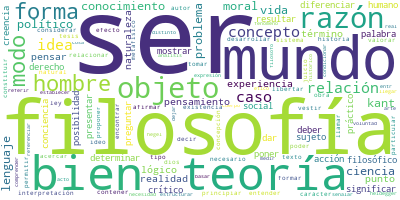

In [8]:
wordcount = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue').generate_from_frequencies(counts)
wordcount.to_image()

### Storing the term-document matrix in a csv

We can use `pandas` to easily store the term-document matrix:

In [9]:
df = pd.DataFrame(X.todense(), columns=vec.get_feature_names(), index=[a.id for a in corpusList])

In [10]:
df

,10,abaj,abajar,abandon,abandonar,abandonarse,abanicar,abar,abarcador,abarcar,...,úni,únicamente,único,útil,übe,über,überhaupt,łłł,žižek,καὶ
21713,0,0,0,0,0,0,0,0,0,0,...,0,0,9,0,0,0,0,0,0,0
59534,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
14518,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42051,0,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1508,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
28726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36692,0,0,0,0,0,0,1,0,0,0,...,0,0,6,0,0,0,0,0,0,0


TODO: add `aa` and `ab` to the stopwords lists.

In [11]:
with open("../data/tdm.csv", "w") as fp:
    fp.write(df.to_csv(index=False))

## Fitting an LDA

In [12]:
n_topics = 20 # k in our notation.

LDA = LatentDirichletAllocation(n_components=n_topics)
LDA.fit(X)

LatentDirichletAllocation(n_components=20)

In [14]:
n_top_words = 10

In [15]:
topic_df = pd.DataFrame()
for topic_idx, topic in enumerate(LDA.components_):
    name = "Topic #%d: " % topic_idx
    words = [df.columns[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    topic_df[name] = words

topic_df

,Topic #0:,Topic #1:,Topic #2:,Topic #3:,Topic #4:,Topic #5:,Topic #6:,Topic #7:,Topic #8:,Topic #9:,Topic #10:,Topic #11:,Topic #12:,Topic #13:,Topic #14:,Topic #15:,Topic #16:,Topic #17:,Topic #18:,Topic #19:
0,husserl,acción,político,metro,ser,ser,aristóteles,ser,arte,entr,físico,lenguaje,político,metáfora,hermenéutico,hume,ser,kant,moral,creencia
1,conciencia,ser,foucault,right,dios,experiencia,ser,texto,social,mism,matemático,objeto,filosofía,significar,nietzsche,ser,filosofía,ser,vida,teoría
2,objeto,moral,ciudad,wit,derecho,cuerpo,naturaleza,dios,marx,otr,ciencia,lógico,derecho,lenguaje,gadamer,natural,heidegger,hombre,ser,justificación
3,percepción,razón,hombre,world,quod,mental,virtud,palabra,histórico,tien,teoría,ser,social,davidson,sartre,teoría,hegel,libertar,hombre,razonar
4,acto,accionar,derecho,one,proposición,conciencia,bien,bien,clase,filosofía,movimiento,teoría,universidad,semántico,interpretación,biológico,mundo,razón,bien,ser
5,experiencia,agente,guerra,kan,falso,creencia,forma,obra,sistema,idea,científico,mundo,filosófico,metafórico,texto,desear,ciencia,derecho,ético,argumentar
6,conocimiento,libertar,gobernar,wha,necesario,mente,alma,nombre,historia,mund,natural,concepto,sociedad,interpretación,lévinas,selección,concepto,naturaleza,sentimiento,justificar
7,trascendental,caso,natural,theory,modo,contener,caso,religioso,forma,bie,mundo,significar,autor,función,ser,quine,realidad,moral,amor,racionalidad
8,fenomenología,bien,ley,fro,causar,intencional,aristotélico,platón,modo,deb,ley,término,vida,capacidad,diálogo,oración,pensamiento,ley,juicio,argumentación
9,relación,causar,vida,hav,futuro,mundo,modo,mundo,teoría,valorar,sistema,caso,ético,contexto,ricoeur,observacional,experiencia,concepto,razón,idea


TODO: add Portuguese words to the stoplist.

## Saving the LDA model using `joblib`

We can save the model using `joblib`, as is recommended in the scikit-learn documentation.

In [14]:
from joblib import dump, load

In [15]:
dump(LDA, f"LDA_k_{n_topics}.jl")

['LDA_k_20.jl']

Notice that we are using f-strings to label how many topics we used to train our model.

This means that, once the model is trained, we can load it and continue the process from here.

In [16]:
LDA = load("LDA_k_50.jl")

In [17]:
LDA

LatentDirichletAllocation(n_components=50)